# Misclassified eamples for ResNet34 and ResNet34 Fusion

In [119]:
import os
import sys
import glob
import shutil
import random
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import time
import copy
from tqdm import tqdm
from pathlib import Path


import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.utils.data
from torchvision.models import resnet34, inception_v3
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
from functions import*
from models import*

# Set it to use GPU1
torch.cuda.set_device(0)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

/home/rene/code/idc/src
True
0


In [158]:
import pandas as pd

def random_from_class(df, category, return_correct=True, num_per_class=4, rows=2, title=False):
    """df: labels, preds, locs"""
    print(len(df))
    # Only look at examples that are actually normal
    df = df.loc[df['labels']==category]
    print(len(df))
    if return_correct:
        df = df.loc[df['labels']==df['preds']]
    else: 
        df = df.loc[df['labels']!=df['preds']]
        
    print(len(df))
        
    img_locs = random.sample(list(df['locs']), num_per_class)
    fig = plt.figure(figsize=(8, 8))
    for ind, img_loc in enumerate(img_locs):
        img=np.asarray(Image.open(img_loc))
        ax2 = fig.add_subplot(rows, int(num_per_class/rows), ind+1)
        plt.imshow(img)
        plt.axis('off')
    if title:
        plt.suptitle(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout(rect=[0, .05, 1, 0.95])
    plt.show()



## ResNet 34

In [10]:
model_arch = resnet34
model_name = 'resnet34_2'

save_path = '/home/rene/data/idc/models'
PATH = '/home/rene/data/idc'
num_workers = 4
batch_size=64
dataloaders, dataset_sizes = make_batch_gen(PATH, batch_size, num_workers, 
                                            valid_name='valid', test_name='test', size=197, return_locs=True)

# get the proper model architecture
model_ft = model_arch(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.cuda()

# load the saved weights
model_ft.load_state_dict(torch.load(os.path.join(save_path, model_name)))

In [12]:
all_labels_r34, all_preds_r34, all_locs_r34 = get_preds_locs(model_ft, dataloaders['test'], dataset_sizes['test'])
metrics = get_metrics_bin(all_labels, all_preds)
print(f'Test sensitivity: {metrics["TPR"]}, specificity: {metrics["TNR"]}, Acc: {metrics["ACC"]}')

Test sensitivity: 0.922548242135871, specificity: 0.8292124945006599, Acc: 0.8970669485214634


In [29]:
df = pd.DataFrame({'labels':all_labels_r34, 'preds': all_preds_r34, 'locs':all_locs_r34})
print(df.shape)
df.head()

(41629, 3)


,labels,preds,locs
0,0,0,/home/rene/data/idc/test/0/15902_idx5_x601_y10...
1,0,0,/home/rene/data/idc/test/0/10288_idx5_x1751_y1...
2,0,0,/home/rene/data/idc/test/0/8980_idx5_x1651_y25...
3,0,0,/home/rene/data/idc/test/0/10272_idx5_x2901_y1...
4,0,0,/home/rene/data/idc/test/0/12822_idx5_x1801_y6...


41629
1941


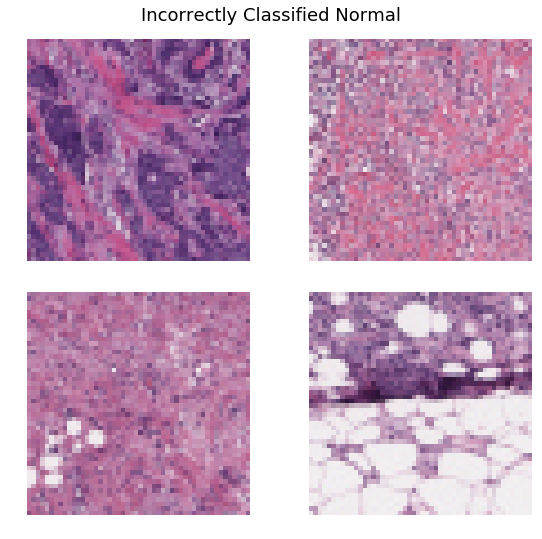

In [72]:
random_from_class(df, 0, return_correct=False, title='Incorrectly Classified Normal')

41629
2344


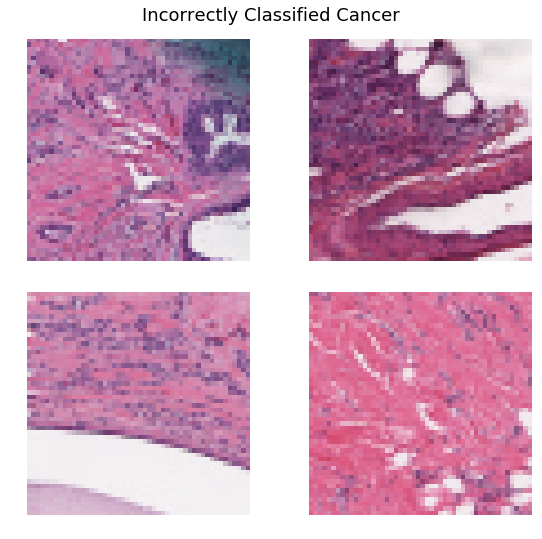

In [67]:
random_from_class(df, 1, return_correct=False, title='Incorrectly Classified Cancer')

## Fusion Model

In [80]:
PATH = '/home/rene/data/idc'
save_path =  Path(PATH, 'models')

model_list = [resnet34, resnet34, resnet34]
model_name_list = ['resnet34_0', 'resnet34_5', 'resnet34_2']

pretrained_model_list = []
for idx, model_arch in enumerate(model_list):
    model_ft = model_arch(pretrained=False)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)
    model_ft = model_ft.cuda()
    model_ft.load_state_dict(torch.load(os.path.join(save_path, model_name_list[idx])))
    pretrained_model_list.append(model_ft)

model_ft = Fusion2Hardcode(pretrained_model_list)

dataloaders, dataset_sizes= make_batch_gen(PATH, batch_size, num_workers, 
                                                        valid_name='valid', test_name='test', size=197, return_locs=True)

fusion_model = Fusion2Hardcode(pretrained_model_list)
fusion_model = fusion_model.cuda()

fusion_model.load_state_dict(torch.load(os.path.join(save_path, 'Fusion2_2s2-test-full-data')))
batch_size = 6
num_workers = 6

In [81]:
labels_f, preds_f, locs_f = get_preds_locs(fusion_model, dataloaders['test'], dataset_sizes['test'])
metrics = get_metrics_bin(all_labels, all_preds)
print(f'Test sensitivity: {metrics["TPR"]}, specificity: {metrics["TNR"]}, Acc: {metrics["ACC"]}')

df_fusion = pd.DataFrame({'labels':labels_f, 'preds': preds_f, 'locs':locs_f})
print(df_fusion.shape)
df_fusion.head()

Test sensitivity: 0.922548242135871, specificity: 0.8292124945006599, Acc: 0.8970669485214634
(41629, 3)


,labels,preds,locs
0,0,0,/home/rene/data/idc/test/0/13022_idx5_x1851_y2...
1,0,0,/home/rene/data/idc/test/0/10285_idx5_x1801_y1...
2,1,0,/home/rene/data/idc/test/1/9077_idx5_x1751_y16...
3,0,0,/home/rene/data/idc/test/0/12911_idx5_x2351_y2...
4,0,0,/home/rene/data/idc/test/0/12878_idx5_x701_y60...


41629
1694


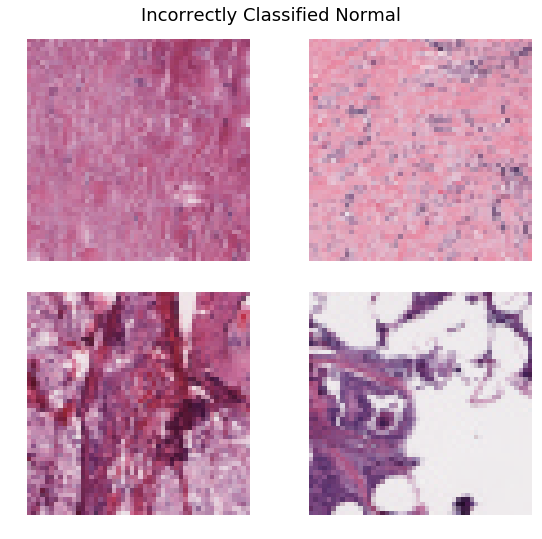

In [82]:
random_from_class(df_fusion, 0, return_correct=False, title='Incorrectly Classified Normal')

41629
2088


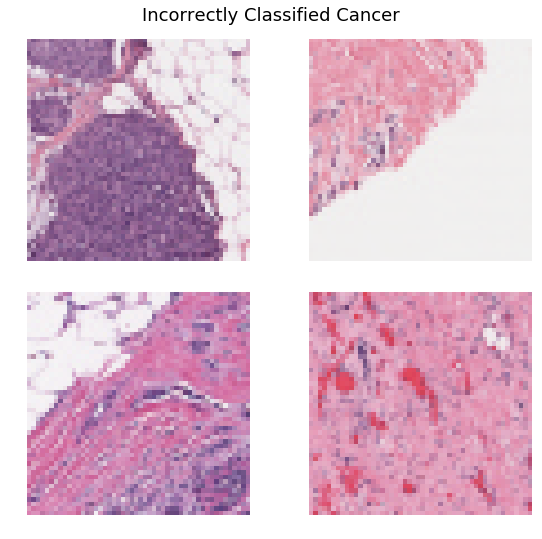

In [83]:
random_from_class(df_fusion, 1, return_correct=False, title='Incorrectly Classified Cancer')

## Where did they both go wrong?

In [94]:
df_both = pd.merge(df, df_fusion, on='locs', suffixes=('', '_fusion'))
df_both = df_both.drop(columns=['labels_fusion'])
df_both.head()

,labels,preds,locs,preds_fusion
0,0,0,/home/rene/data/idc/test/0/15902_idx5_x601_y10...,0
1,0,0,/home/rene/data/idc/test/0/10288_idx5_x1751_y1...,0
2,0,0,/home/rene/data/idc/test/0/8980_idx5_x1651_y25...,0
3,0,0,/home/rene/data/idc/test/0/10272_idx5_x2901_y1...,0
4,0,0,/home/rene/data/idc/test/0/12822_idx5_x1801_y6...,0


In [97]:
print(df_both.shape)
df_both_same = df_both.loc[df_both['preds']==df_both['preds_fusion']]
print(df_both_same.shape)

(41629, 4)
(39740, 4)


In [162]:
def random_from_class(df, category, return_correct=True, num_per_class=4, rows=2, title=False):
    """df: labels, preds, locs"""
    # Only look at examples that are actually normal
    df = df.loc[df['labels']==category]
    if return_correct:
        df = df.loc[df['labels']==df['preds']]
    else: 
        df = df.loc[df['labels']!=df['preds']]
                
    img_locs = random.sample(list(df['locs']), num_per_class)
    fig = plt.figure(figsize=(8, 8))
    for ind, img_loc in enumerate(img_locs):
        img=np.asarray(Image.open(img_loc))
        ax2 = fig.add_subplot(rows, int(num_per_class/rows), ind+1)
        plt.imshow(img)
        plt.axis('off')
    if title:
        plt.suptitle(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout(rect=[0, .6, 1, 0.98])
    plt.show()

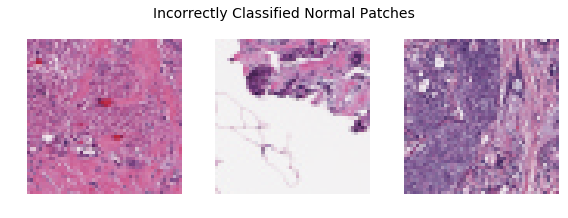

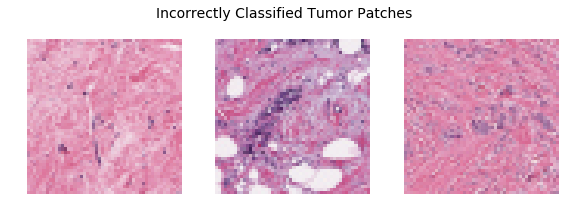

In [170]:

random_from_class(df_both_same, 0, return_correct=False, num_per_class=3, rows=1, title='Incorrectly Classified Normal Patches')

random_from_class(df_both_same, 1, return_correct=False, num_per_class=3, rows=1, title='Incorrectly Classified Tumor Patches')


39740
28860
27543


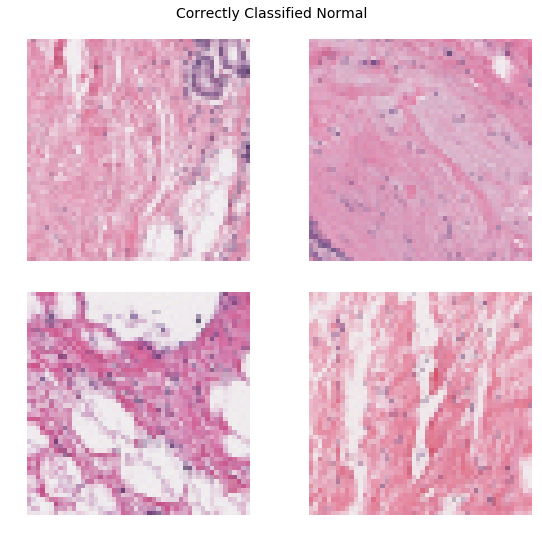

In [159]:
random_from_class(df_both_same, 0, return_correct=True, num_per_class=4, rows=2, title='Correctly Classified Normal')

39740
10880
9108


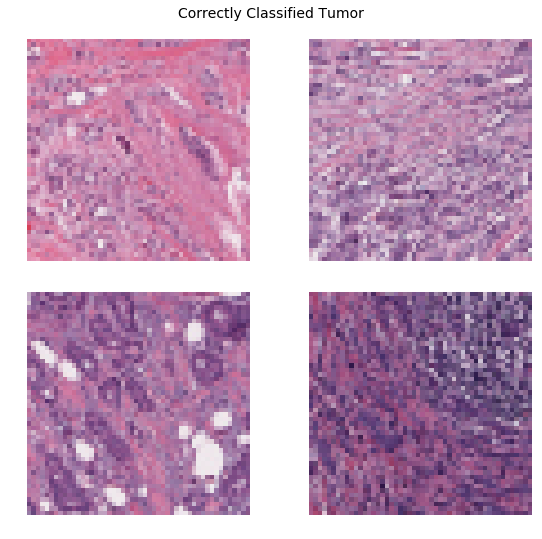

In [160]:
random_from_class(df_both_same, 1, return_correct=True, title='Correctly Classified Tumor')

In [152]:
print(df.shape)

(41629, 3)
